<a href="https://colab.research.google.com/github/pahan242/MyGit_216094A/blob/master/Big_Data_Individual_216094A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dask[complete] distributed matplotlib seaborn plotly
!apt-get install -y fonts-nanum

import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_palette("viridis")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (24.4 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
file_path = "/content/drive/MyDrive/air_quality.csv"
ddf = dd.read_csv(file_path, assume_missing=True, na_values=['-', 'ND'])

# Explicitly cast relevant columns to float64 immediately after loading
numeric_cols_to_cast = ['aqi', 'pm2.5', 'pm10', 'so2', 'co', 'o3', 'o3_8hr', 'no2', 'nox', 'no', 'windspeed', 'winddirec',
                        'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg', 'longitude', 'latitude', 'siteid']
for col_name in numeric_cols_to_cast:
    if col_name in ddf.columns:
        ddf[col_name] = ddf[col_name].astype('float64')


print(f"Dataset partitions: {ddf.npartitions}")
print(f"Estimated rows: {len(ddf):,}")
ddf.head()

Dataset partitions: 13
Estimated rows: 5,882,208


,date,sitename,county,aqi,pollutant,status,so2,co,o3,o3_8hr,...,windspeed,winddirec,unit,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2024-08-31 23:00,Hukou,Hsinchu County,62.0,PM2.5,Moderate,0.9,0.17,35.0,40.2,...,2.3,225.0,NaN,0.2,20.1,26.0,1.0,121.038869,24.900097,22.0
1,2024-08-31 23:00,Zhongming,Taichung City,50.0,<NA>,Good,1.6,0.32,27.9,35.1,...,1.1,184.0,NaN,0.2,15.3,23.0,1.0,120.641092,24.151958,31.0
2,2024-08-31 23:00,Zhudong,Hsinchu County,45.0,<NA>,Good,0.4,0.17,25.1,40.6,...,0.4,210.0,NaN,0.2,13.8,24.0,0.0,121.088955,24.740914,23.0
3,2024-08-31 23:00,Hsinchu,Hsinchu City,42.0,<NA>,Good,0.8,0.20,30.0,35.9,...,1.9,239.0,NaN,0.2,13.0,26.0,1.0,120.972368,24.805636,24.0
4,2024-08-31 23:00,Toufen,Miaoli County,50.0,<NA>,Good,1.0,0.16,33.5,35.9,...,1.8,259.0,NaN,0.1,15.3,28.0,1.0,120.898693,24.696907,25.0


In [3]:
ddf['date'] = dd.to_datetime(ddf['date'], format='%Y-%m-%d %H:%M', errors='coerce')
ddf = ddf.dropna(subset=['date'])

ddf['year'] = ddf['date'].dt.year
ddf['month'] = ddf['date'].dt.month
ddf['day_of_week'] = ddf['date'].dt.dayofweek
ddf['hour'] = ddf['date'].dt.hour
ddf['season'] = ddf['month'].apply(lambda x: 'Winter' if x in [12,1,2] else
                                  'Spring' if x in [3,4,5] else
                                  'Summer' if x in [6,7,8] else 'Fall', meta=('season', 'object'))

critical_cols = ['aqi', 'county', 'pm2.5', 'pm10']
ddf_clean = ddf.dropna(subset=critical_cols)
print(f"Records after cleaning: {len(ddf_clean):,}")

Records after cleaning: 5,591,196


In [4]:
numeric_stats = ddf_clean[['aqi', 'pm2.5', 'pm10', 'o3', 'no2', 'so2', 'co']].describe().compute()
print("Summary Statistics:")
print(numeric_stats)

county_counts = ddf_clean['county'].value_counts().compute()
print("\nRecords per County:")
print(county_counts.sort_values(ascending=False))

status_counts = ddf_clean['status'].value_counts().compute()
print("\nAir Quality Status Distribution:")
print(status_counts.sort_values(ascending=False))

pollutant_counts = ddf_clean['pollutant'].value_counts().compute()
print("\nPrimary Pollutant Distribution:")
print(pollutant_counts)

Summary Statistics:
                aqi         pm2.5          pm10            o3           no2  \
count  5.591196e+06  5.591196e+06  5.591196e+06  5.457353e+06  5.499008e+06   
mean   5.481695e+01  1.687354e+01  3.468742e+01  3.046556e+01  1.132166e+01   
std    2.983930e+01  1.271115e+01  2.432778e+01  1.837709e+01  8.700422e+00   
min   -1.000000e+00 -9.990000e+02 -9.990000e+02 -9.990000e+02 -2.778000e+01   
25%    3.800000e+01  1.000000e+01  2.300000e+01  2.200000e+01  6.700000e+00   
50%    5.700000e+01  1.700000e+01  3.500000e+01  3.500000e+01  1.130000e+01   
75%    9.200000e+01  3.200000e+01  6.500000e+01  4.800000e+01  1.900000e+01   
max    5.000000e+02  1.000000e+03  1.407000e+03  4.100000e+02  3.510500e+02   

                so2            co  
count  5.520243e+06  5.501885e+06  
mean   1.995151e+00  3.405633e-01  
std    1.884118e+00  1.230671e+00  
min   -9.990000e+02 -9.990000e+02  
25%    1.400000e+00  2.200000e-01  
50%    1.900000e+00  3.300000e-01  
75%    3.600000e

In [5]:
county_analysis = ddf_clean.groupby('county').agg({
    'aqi': ['mean', 'std', 'max'],
    'pm2.5': ['mean', 'max'],
    'pm10': ['mean', 'max'],
    'siteid': 'count'
}).compute()

county_analysis.columns = ['avg_aqi', 'std_aqi', 'max_aqi', 'avg_pm25', 'max_pm25', 'avg_pm10', 'max_pm10', 'station_count']
county_analysis = county_analysis.sort_values('avg_aqi', ascending=False)
print("County-level Analysis:")
print(county_analysis)

County-level Analysis:
                     avg_aqi    std_aqi  max_aqi   avg_pm25  max_pm25  \
county                                                                  
Kaohsiung City     67.694529  35.376034    247.0  22.288436    1000.0   
Chiayi City        66.650238  36.230864    179.0  22.110455    1000.0   
Kinmen County      65.429951  33.935907    232.0  20.806482     229.0   
Lienchiang County  63.425957  30.977232    221.0  18.774660     213.0   
Chiayi County      63.413639  32.612693    399.0  20.377932    1000.0   
Yunlin County      62.946836  33.820810    500.0  20.130196     295.0   
Tainan City        62.567722  33.536953    225.0  20.354306    1000.0   
Nantou County      61.646886  31.934502    214.0  19.900157     135.0   
Pingtung County    57.726591  33.417642    212.0  17.376499     178.0   
Changhua County    57.556713  29.795661    500.0  18.080340    1000.0   
Taichung City      54.312815  28.118542    208.0  17.006616     190.0   
Miaoli County      50.320983

In [6]:
temporal_analysis = ddf_clean.groupby(['year', 'month']).agg({
    'aqi': 'mean',
    'pm2.5': 'mean',
    'pm10': 'mean',
    'date': 'count'
}).compute()

temporal_analysis.columns = ['avg_aqi', 'avg_pm25', 'avg_pm10', 'readings']
temporal_analysis = temporal_analysis.sort_values(['year', 'month'])
print("Temporal Analysis (Year-Month):")
print(temporal_analysis.head(12))

Temporal Analysis (Year-Month):
              avg_aqi   avg_pm25   avg_pm10  readings
year month                                           
2016 11     54.095708  18.119635  43.877158      8108
     12     77.253518  26.223162  56.978957     53795
2017 1      77.392858  26.287024  54.981105     53877
     2      80.435416  27.512292  56.964728     48650
     3      84.837970  28.808797  58.214602     54021
     4      76.815832  24.669086  49.065684     52083
     5      61.966916  19.218602  41.232126     53682
     6      39.345275  11.738302  28.488286     49045
     7      43.653331  13.392274  30.381133     50893
     8      47.232948  14.816709  32.721050     52823
     9      62.326596  19.823808  39.950096     52000
     10     63.747292  20.020064  48.634731     53180


In [7]:
seasonal_analysis = ddf_clean.groupby(['year', 'season']).agg({
    'aqi': 'mean',
    'pm2.5': 'mean'
}).compute()

seasonal_analysis.columns = ['avg_aqi', 'avg_pm25']
seasonal_analysis = seasonal_analysis.sort_values(['year', 'season'])
print("Seasonal Analysis:")
print(seasonal_analysis)

Seasonal Analysis:
               avg_aqi   avg_pm25
year season                      
2016 Fall    54.095708  18.119635
     Winter  77.253518  26.223162
2017 Fall    64.193716  20.580163
     Spring  74.539315  24.237499
     Summer  43.507990  13.353808
     Winter  77.165305  26.258739
2018 Fall    63.741169  19.623536
     Spring  70.170217  22.662943
     Summer  44.213693  13.138907
     Winter  69.419334  23.031462
2019 Fall    61.111290  18.518376
     Spring  64.119618  20.019165
     Summer  37.528969  11.097618
     Winter  65.629119  21.511253
2020 Fall    54.462266  15.735514
     Spring  58.128858  17.416610
     Summer  29.037944   7.997251
     Winter  61.242852  19.542321
2021 Fall    47.801962  13.808254
     Spring  61.127089  19.157122
     Summer  30.934093   8.334028
     Winter  70.734835  23.457386
2022 Fall    50.074965  13.901172
     Spring  55.126595  16.474873
     Summer  28.558027   7.530041
     Winter  52.767668  15.679133
2023 Fall    49.258667  14.02

In [8]:
hourly_analysis = ddf_clean.groupby('hour').agg({
    'aqi': 'mean',
    'pm2.5': 'mean',
    'pm10': 'mean'
}).compute()

hourly_analysis.columns = ['avg_aqi', 'avg_pm25', 'avg_pm10']
print("Hourly Pattern Analysis:")
print(hourly_analysis)

Hourly Pattern Analysis:
        avg_aqi   avg_pm25   avg_pm10
hour                                 
23    54.710467  16.852276  34.081236
22    55.399546  17.031740  34.730674
21    56.272796  17.087082  35.239790
20    57.405152  17.008562  35.695553
19    58.418082  16.732235  36.058979
18    58.787139  16.435882  36.477866
17    58.212736  16.308088  36.795060
16    57.027080  16.377883  36.765257
15    55.982022  16.644700  36.637013
14    55.423553  16.988926  36.017430
13    55.074432  17.396652  35.866025
12    54.894378  17.843707  36.811619
11    54.566818  18.052042  36.828841
10    53.934319  18.046691  36.345794
9     53.242032  17.830106  35.584401
8     52.693607  17.333295  34.484564
7     52.321971  16.577734  32.640385
6     52.280068  16.153071  31.495277
5     52.426335  16.072964  31.354543
4     52.695812  16.152457  31.689966
3     52.925764  16.270038  31.994224
2     53.193224  16.405448  32.278861
1     53.670916  16.744310  33.495611
0     54.095397  16.69109

In [9]:
yearly_analysis = ddf_clean.groupby('year').agg({
    'aqi': 'mean',
    'pm2.5': 'mean',
    'pm10': 'mean'
}).compute()

yearly_analysis.columns = ['aqi', 'pm2.5', 'pm10']
print("Yearly Analysis:")
print(yearly_analysis)

Yearly Analysis:
            aqi      pm2.5       pm10
year                                 
2024  49.860032  14.906380  28.716942
2023  49.851784  14.836703  30.783446
2022  46.631787  13.395797  26.967182
2021  55.312052  17.210041  33.419229
2020  51.015473  15.289917  30.748514
2019  57.698828  17.986177  36.843971
2018  62.139249  19.705777  43.978212
2017  65.044437  21.177600  45.648535
2016  74.220329  25.161769  55.262895


In [10]:
station_analysis = ddf_clean.groupby(['county', 'sitename']).agg({
    'longitude': 'first',
    'latitude': 'first',
    'aqi': 'mean',
    'pm2.5': 'mean'
}).compute()

station_analysis.columns = ['longitude', 'latitude', 'avg_aqi', 'avg_pm25']
print("Station-level Analysis:")
print(station_analysis.head())

Station-level Analysis:
                           longitude   latitude    avg_aqi   avg_pm25
county          sitename                                             
Taichung City   Fengyuan  120.741711  24.256586  52.411933  16.350085
Tainan City     Shanhua   120.297142  23.115097  63.299836  20.771160
Nantou County   Puli      120.967903  23.968842  57.091210  17.881975
New Taipei City Xindian   121.537778  24.977222  44.900081  12.816182
Taichung City   Xitun     120.616917  24.162197  57.504717  18.285937


In [11]:
# Calculate unhealthy days (AQI > 100) by County
unhealthy_data = ddf_clean[ddf_clean['aqi'] > 100]

# Extract date part and count unique dates per county using Dask operations
unhealthy_days = unhealthy_data.groupby('county')['date'].apply(
    lambda x: x.dt.date.drop_duplicates().count(),
    meta=('date_count', 'int64') # Provide meta for Dask to infer the output type
).compute()

unhealthy_days = unhealthy_days.reset_index()
unhealthy_days.columns = ['county', 'unhealthy_days']

# Calculate average unhealthy AQI by County
avg_unhealthy_aqi = unhealthy_data.groupby('county')['aqi'].mean().compute()
avg_unhealthy_aqi = avg_unhealthy_aqi.reset_index()
avg_unhealthy_aqi.columns = ['county', 'avg_unhealthy_aqi']

# Merge the two results
unhealthy_days_analysis = pd.merge(unhealthy_days, avg_unhealthy_aqi, on='county', how='left')

unhealthy_days_analysis = unhealthy_days_analysis.sort_values('unhealthy_days', ascending=False)
print("Unhealthy Days (AQI > 100) by County:")
print(unhealthy_days_analysis)

Unhealthy Days (AQI > 100) by County:
               county  unhealthy_days  avg_unhealthy_aqi
17     Kaohsiung City            1527         124.330090
7     Pingtung County            1436         122.993247
13      Yunlin County            1276         126.017473
2       Nantou County            1149         122.692184
1         Tainan City            1140         124.483733
14    Changhua County             995         123.689068
11      Chiayi County             991         124.193288
3         Chiayi City             950         126.077784
19      Kinmen County             875         126.658654
5       Taichung City             812         121.754467
10    New Taipei City             775         119.381427
0   Lienchiang County             733         126.595375
12       Taoyuan City             662         122.236115
15      Miaoli County             562         119.551072
4      Hsinchu County             514         120.662673
20        Taipei City             497         117.

In [12]:
unhealthy_pollutant = unhealthy_data.groupby('pollutant').agg({
    'date': 'count',
    'aqi': 'mean'
}).compute()

unhealthy_pollutant.columns = ['occurrences', 'avg_aqi']
unhealthy_pollutant = unhealthy_pollutant.sort_values('occurrences', ascending=False)
print("Primary Pollutants on Unhealthy Days:")
print(unhealthy_pollutant)

Primary Pollutants on Unhealthy Days:
                        occurrences     avg_aqi
pollutant                                      
PM2.5                        405485  123.704482
Ozone (8hr)                   63083  123.337428
PM10                           9229  116.230361
Ozone                            93  112.354839
Sulfur Dioxide (SO2)             75  112.426667
Nitrogen Dioxide (NO2)            6  105.833333
Carbon Monoxide (CO)              2  166.500000


In [13]:
correlation_matrix = ddf_clean[['aqi', 'pm2.5', 'pm10', 'o3', 'no2', 'so2', 'co', 'windspeed']].corr().compute()
print("Correlation Matrix:")
print(correlation_matrix.round(3))

Correlation Matrix:
             aqi  pm2.5   pm10     o3    no2    so2     co  windspeed
aqi        1.000  0.870  0.777  0.290  0.353  0.269  0.068     -0.027
pm2.5      0.870  1.000  0.809  0.164  0.411  0.299  0.079     -0.085
pm10       0.777  0.809  1.000  0.207  0.362  0.306  0.068      0.028
o3         0.290  0.164  0.207  1.000 -0.280  0.037 -0.029      0.358
no2        0.353  0.411  0.362 -0.280  1.000  0.331  0.157     -0.274
so2        0.269  0.299  0.306  0.037  0.331  1.000  0.051     -0.007
co         0.068  0.079  0.068 -0.029  0.157  0.051  1.000     -0.036
windspeed -0.027 -0.085  0.028  0.358 -0.274 -0.007 -0.036      1.000


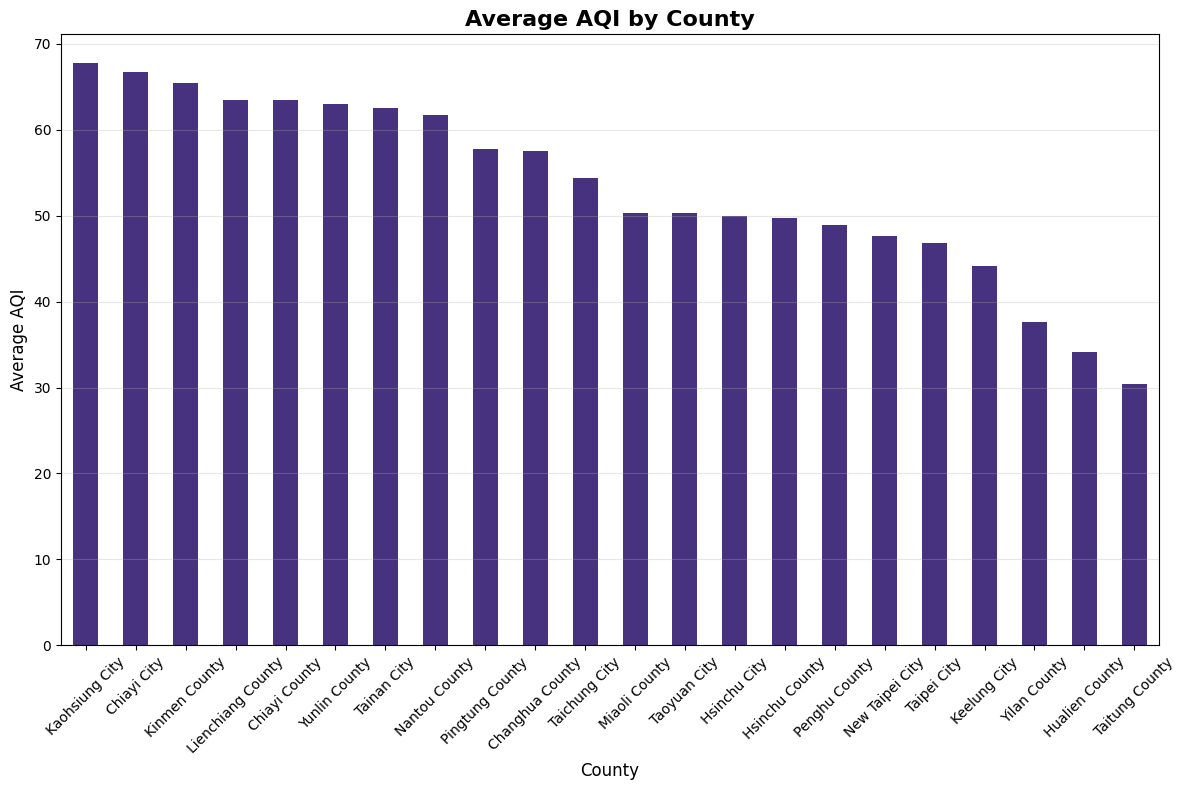

In [14]:
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a standard font
plt.figure(figsize=(12, 8))
county_analysis['avg_aqi'].sort_values(ascending=False).plot(kind='bar')
plt.title('Average AQI by County', fontsize=16, fontweight='bold')
plt.xlabel('County', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

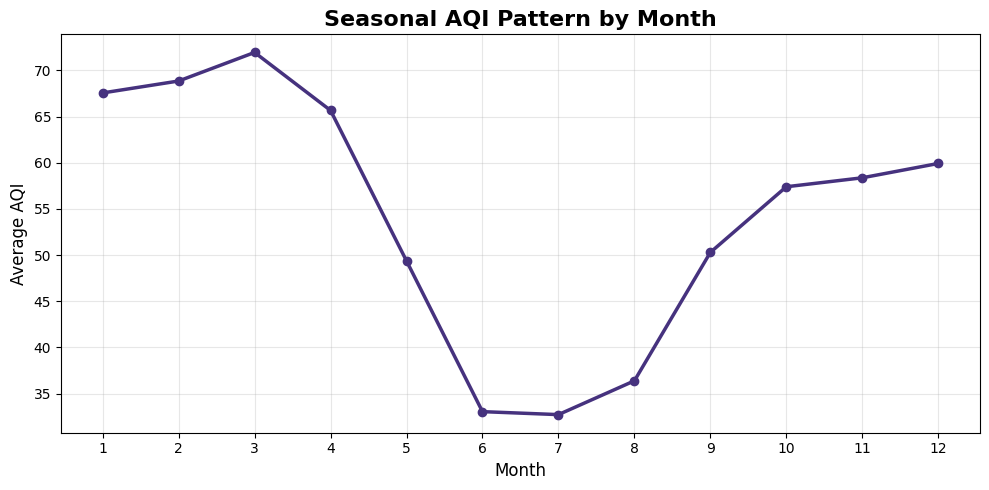

In [15]:
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a standard font
plt.figure(figsize=(10, 5))
monthly_avg = ddf_clean.groupby('month')['aqi'].mean().compute()
monthly_avg.plot(kind='line', marker='o', linewidth=2.5)
plt.title('Seasonal AQI Pattern by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

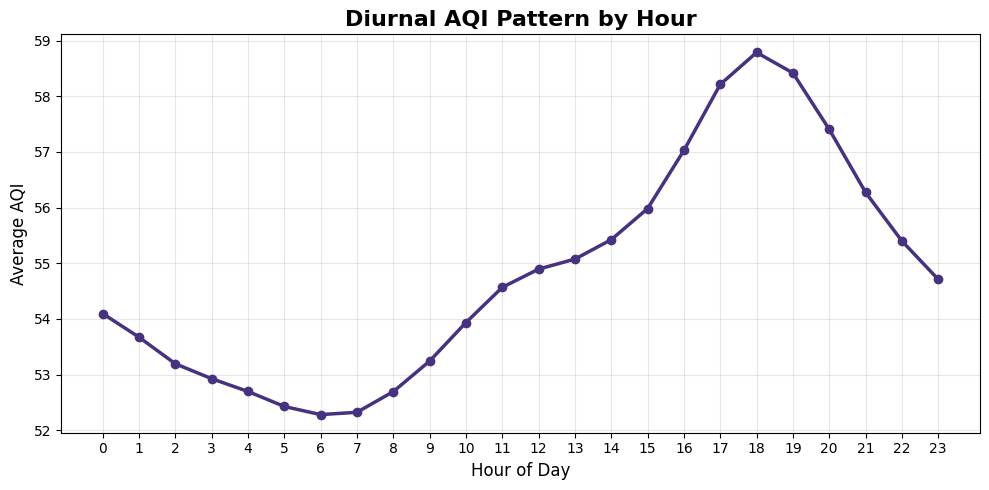

In [16]:
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a standard font
plt.figure(figsize=(10, 5))
hourly_analysis['avg_aqi'].plot(kind='line', marker='o', linewidth=2.5)
plt.title('Diurnal AQI Pattern by Hour', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

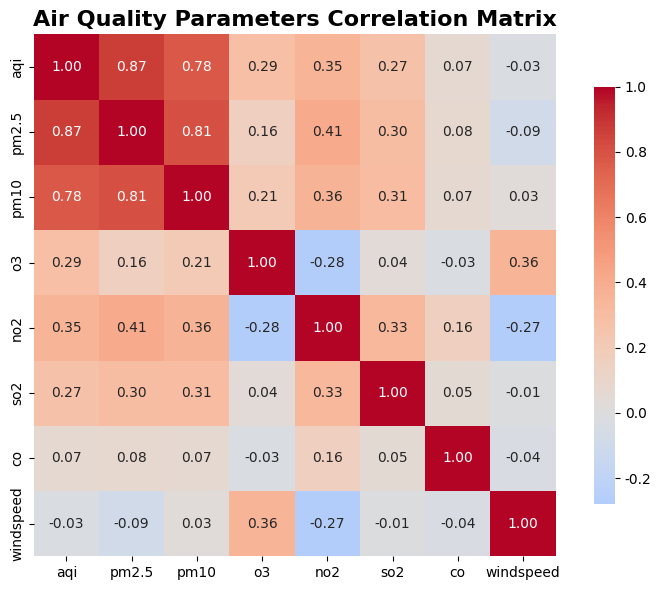

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a standard font
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Air Quality Parameters Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

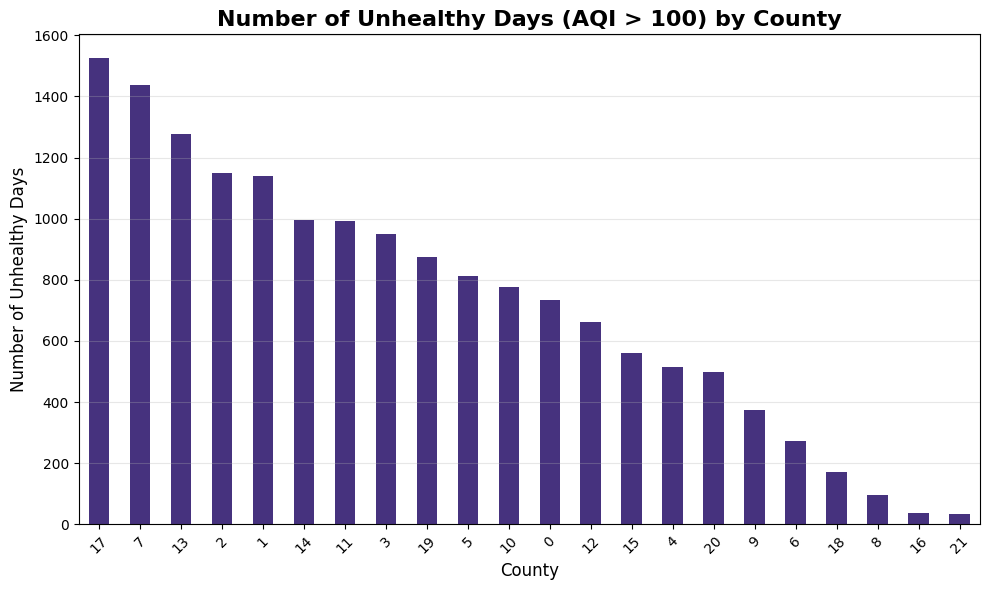

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a standard font
plt.figure(figsize=(10, 6))
unhealthy_days['unhealthy_days'].sort_values(ascending=False).plot(kind='bar')
plt.title('Number of Unhealthy Days (AQI > 100) by County', fontsize=16, fontweight='bold')
plt.xlabel('County', fontsize=12)
plt.ylabel('Number of Unhealthy Days', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

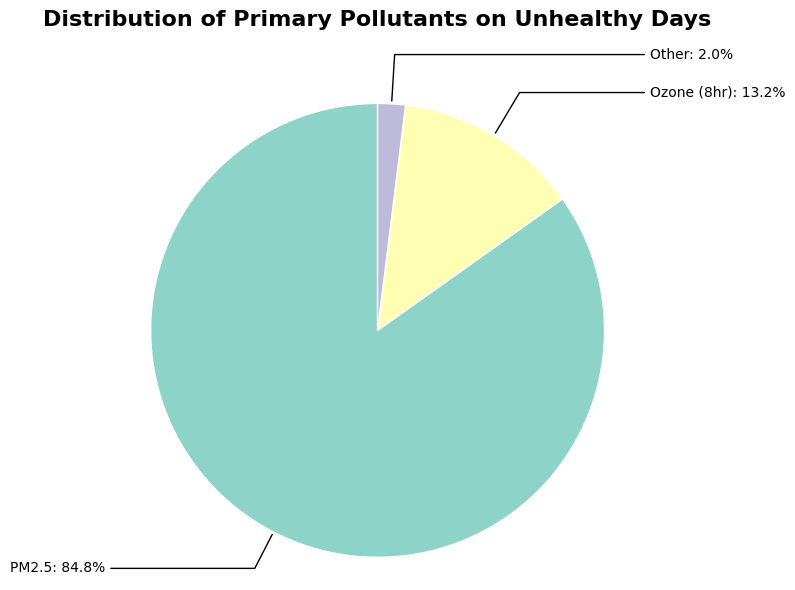

In [19]:
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import re
import numpy as np

# Example DataFrame (replace with your actual one)
# unhealthy_pollutant = pd.DataFrame({'occurrences': [50, 30, 10, 5, 2]}, index=['PM2.5', 'PM10', 'O3', 'NO2', 'CO'])

# --- Convert Plotly colors to Matplotlib RGBA ---
pollutant_colors_rgb = px.colors.qualitative.Set3

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a standard font


def rgb_to_rgba(color_str):
    match = re.match(r'rgb\((\d+),(\d+),(\d+)\)', color_str)
    if match:
        r, g, b = map(int, match.groups())
        return (r / 255.0, g / 255.0, b / 255.0, 1.0)  # normalized RGBA
    else:
        return mcolors.to_rgba(color_str)  # fallback if already valid

pollutant_colors_rgba = [rgb_to_rgba(c) for c in pollutant_colors_rgb]

# --- Prepare and Clean Data ---
values = unhealthy_pollutant['occurrences'].astype(float).fillna(0)
values = values[values > 0]  # filter out non-positive

# Calculate percentage shares
total = values.sum()
percentages = values / total

# Group small categories (<5%) into 'Other'
threshold = 0.05  # 5%
large = values[percentages >= threshold]
small = values[percentages < threshold]

if not small.empty:
    other_value = small.sum()
    values_grouped = pd.concat([large, pd.Series({'Other': other_value})])
else:
    values_grouped = large

# Align colors to grouped categories
colors_cycle = list(itertools.islice(itertools.cycle(pollutant_colors_rgba), len(values_grouped)))

# --- Plot Pie Chart with outside labels ---
plt.figure(figsize=(8, 6))
wedges, texts = plt.pie(
    values_grouped,
    labels=None,  # Hide default labels inside
    colors=colors_cycle,
    startangle=90,
    autopct=None,
    pctdistance=0.85,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Add labels with leader lines outside
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    horizontalalignment = 'left' if x > 0 else 'right'
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    plt.annotate(f"{values_grouped.index[i]}: {values_grouped.values[i]/total:.1%}",
                 xy=(x, y),
                 xytext=(1.2 * np.sign(x), 1.2 * y),
                 horizontalalignment=horizontalalignment,
                 arrowprops=dict(arrowstyle='-', connectionstyle=connectionstyle))

plt.title('Distribution of Primary Pollutants on Unhealthy Days\n\n', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()


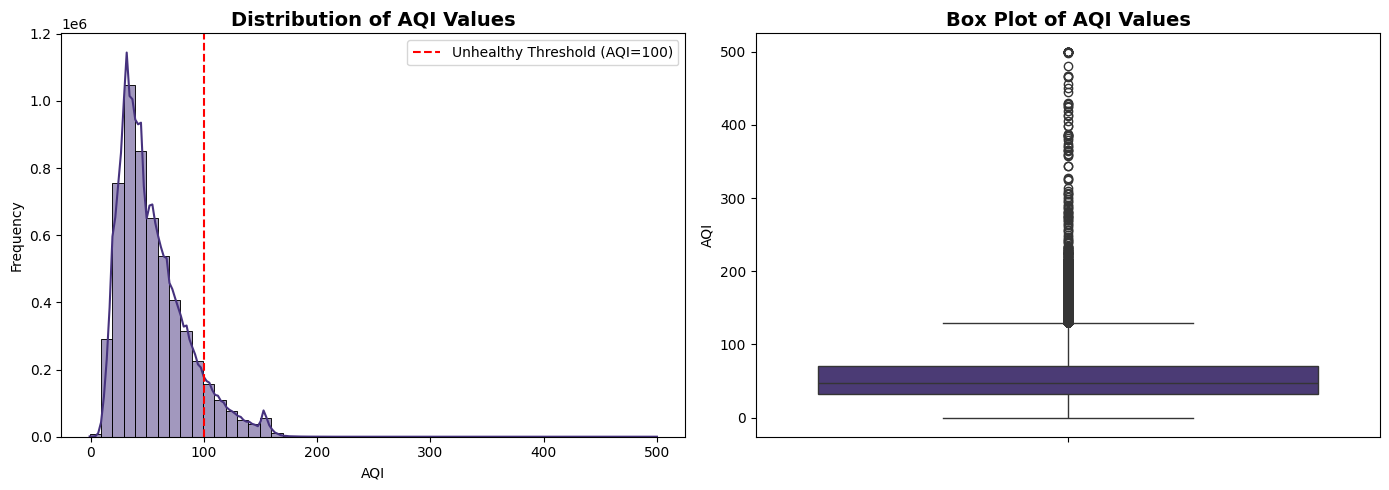

In [20]:
# Distribution of AQI values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
aqi_values = ddf_clean['aqi'].compute()
sns.histplot(aqi_values, bins=50, kde=True)
plt.title('Distribution of AQI Values', fontsize=14, fontweight='bold')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.axvline(x=100, color='red', linestyle='--', label='Unhealthy Threshold (AQI=100)')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(y=aqi_values)
plt.title('Box Plot of AQI Values', fontsize=14, fontweight='bold')
plt.ylabel('AQI')

plt.tight_layout()
plt.show()

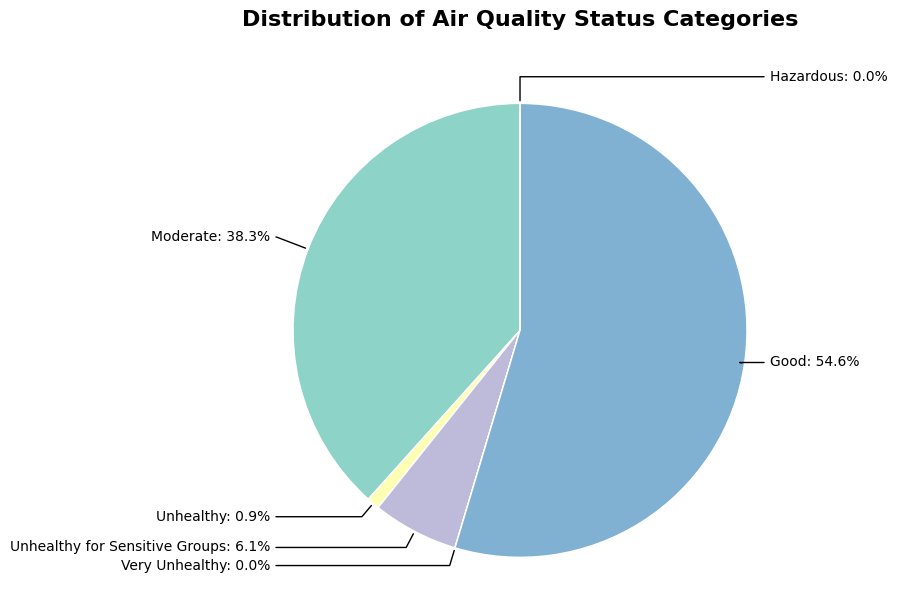

In [21]:
plt.rcParams['font.family'] = 'DejaVu Sans'  # Use a standard font

# --- Convert Plotly colors to Matplotlib RGBA ---
status_colors_rgb = px.colors.qualitative.Set3

import re # Import re for regex
import matplotlib.colors as mcolors # Import mcolors

def rgb_to_rgba(color_str):
    match = re.match(r'rgb\((\d+),(\d+),(\d+)\)', color_str)
    if match:
        r, g, b = map(int, match.groups())
        return (r / 255.0, g / 255.0, b / 255.0, 1.0)
    else:
        return mcolors.to_rgba(color_str)

status_colors_rgba = [rgb_to_rgba(c) for c in status_colors_rgb]

# --- Prepare Data ---
status_counts = ddf_clean['status'].value_counts().compute()
values = status_counts.values.to_numpy() # Convert to NumPy array
labels = status_counts.index

# Align colors to categories
colors_cycle = list(itertools.islice(itertools.cycle(status_colors_rgba), len(labels)))

# --- Plot Pie Chart with outside labels ---
plt.figure(figsize=(8, 6))
wedges, texts = plt.pie(
    values,
    labels=None,  # hide default labels
    colors=colors_cycle,
    startangle=90,
    autopct=None,
    pctdistance=0.85,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Add labels with percentages outside
total = values.sum()
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    horizontalalignment = 'left' if x > 0 else 'right'
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    plt.annotate(f"{labels[i]}: {values[i]/total:.1%}",
                 xy=(x, y),
                 xytext=(1.1 * np.sign(x), 1.1 * y),
                 horizontalalignment=horizontalalignment,
                 arrowprops=dict(arrowstyle='-', connectionstyle=connectionstyle))

plt.title('Distribution of Air Quality Status Categories\n\n', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd

# Convert 'date' to datetime (if not already)
ddf_clean['date'] = dd.to_datetime(ddf_clean['date'])

# Extract month
ddf_clean['month'] = ddf_clean['date'].dt.month

# Define mapping function for seasons
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Map month to season
ddf_clean['season'] = ddf_clean['month'].map_partitions(lambda s: s.apply(month_to_season))

# Select numeric columns only (to avoid NotImplementedError)
numeric_cols = ddf_clean.select_dtypes(include='number').columns

# Group by season and compute mean for numeric columns
seasonal_analysis = ddf_clean.groupby('season')[numeric_cols].mean().compute()


# (Optional) Sort in natural seasonal order
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_analysis = seasonal_analysis.reindex(season_order)

print(seasonal_analysis)

              aqi       so2        co         o3     o3_8hr       pm10  \
season                                                                   
Winter  65.570894  2.039834  0.416693  30.412352  30.422185  41.584805   
Spring  62.379416  2.089736  0.362483  34.302602  34.327276  38.513271   
Summer  34.033917  1.811959  0.247728  22.684003  22.701256  21.767112   
Autumn  55.430958  2.025529  0.324415  34.421550  34.462993  35.963840   

            pm2.5        no2        nox        no  ...  pm2.5_avg   pm10_avg  \
season                                             ...                         
Winter  21.311069  13.884435  18.033746  4.134511  ...  21.285199  41.361015   
Spring  19.363348  12.063362  15.413510  3.335370  ...  19.360296  38.296732   
Summer   9.602216   8.191747  11.469587  3.260430  ...   9.538059  21.454923   
Autumn  16.458694  10.762558  13.741080  2.964736  ...  16.420979  35.692740   

         so2_avg   longitude   latitude     siteid         year      month

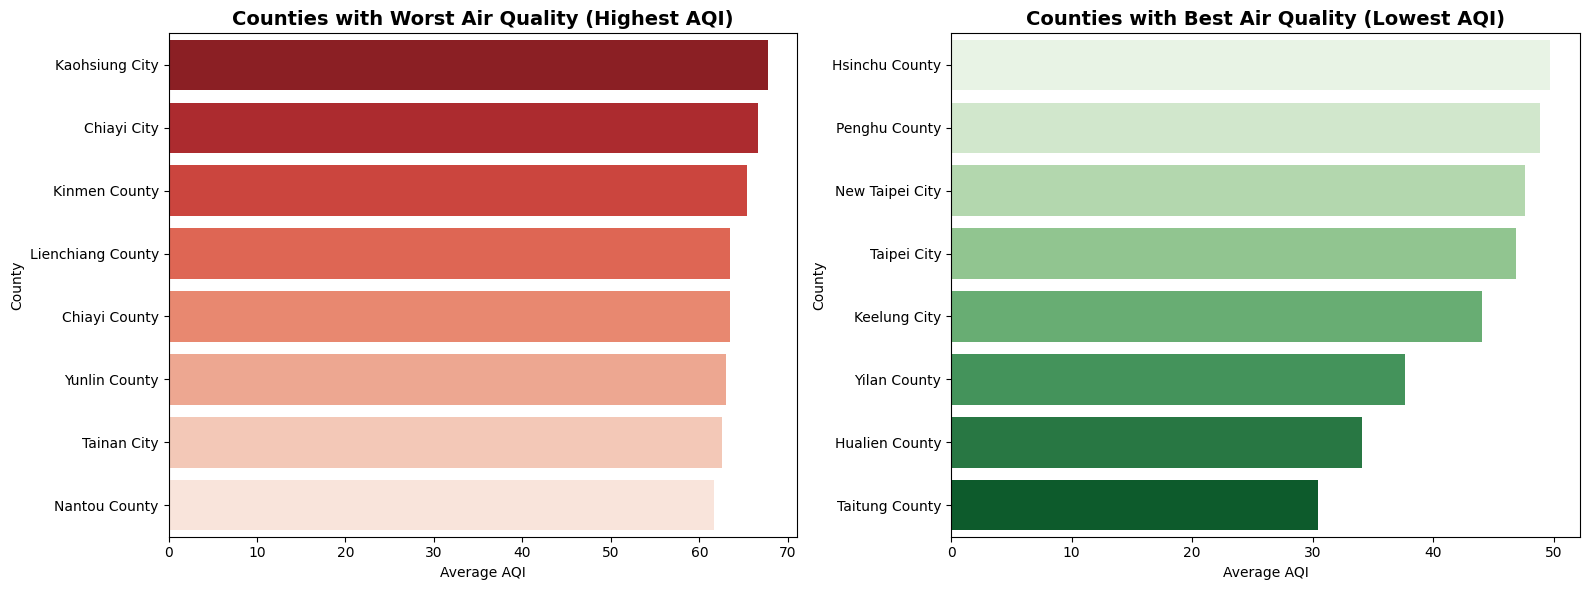

In [23]:
# 6. Geographic Distribution - Top and Bottom counties
top_counties = county_analysis.head(8)
bottom_counties = county_analysis.tail(8)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=top_counties['avg_aqi'], y=top_counties.index, palette='Reds_r')
plt.title('Counties with Worst Air Quality (Highest AQI)', fontsize=14, fontweight='bold')
plt.xlabel('Average AQI')
plt.ylabel('County')

plt.subplot(1, 2, 2)
sns.barplot(x=bottom_counties['avg_aqi'], y=bottom_counties.index, palette='Greens')
plt.title('Counties with Best Air Quality (Lowest AQI)', fontsize=14, fontweight='bold')
plt.xlabel('Average AQI')
plt.ylabel('County')

plt.tight_layout()
plt.show()

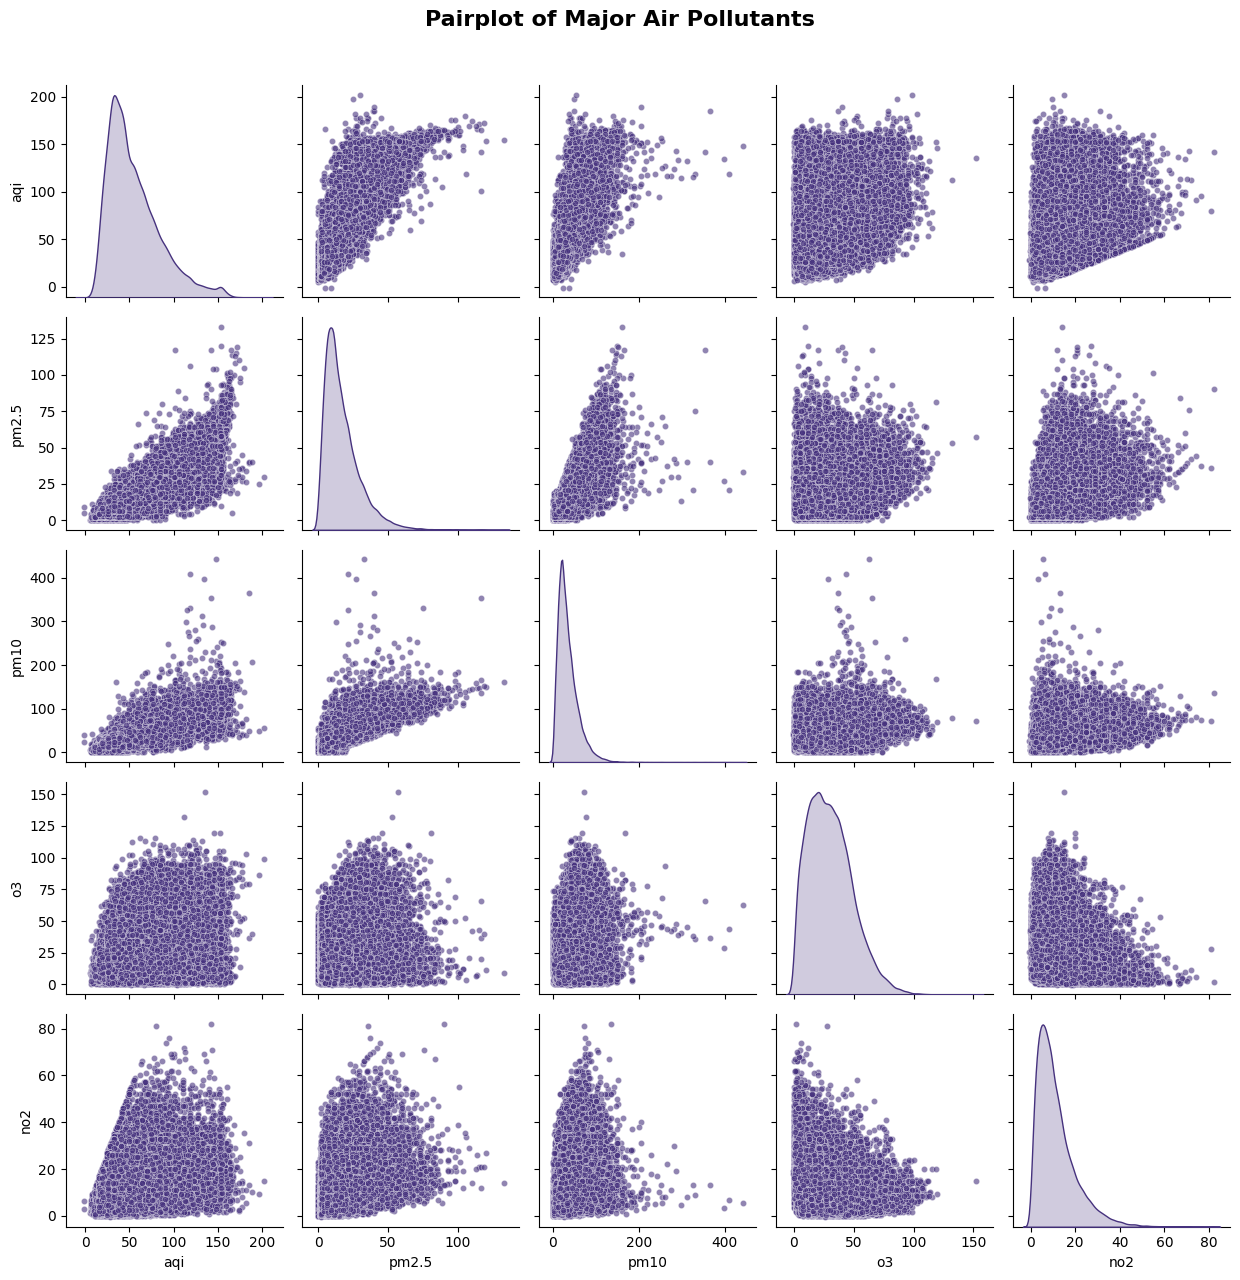

In [24]:
# 8. Pollutant Pairplot for relationships
sample_data = ddf_clean.sample(frac=0.01).compute()  # Sample for performance

# Select only the necessary columns, ensuring no duplicates
plot_cols = ['aqi', 'pm2.5', 'pm10', 'o3', 'no2']
sample_data_for_plot = sample_data[plot_cols].reset_index(drop=True)


g = sns.pairplot(sample_data_for_plot,
                 diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20})
g.fig.suptitle('Pairplot of Major Air Pollutants', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

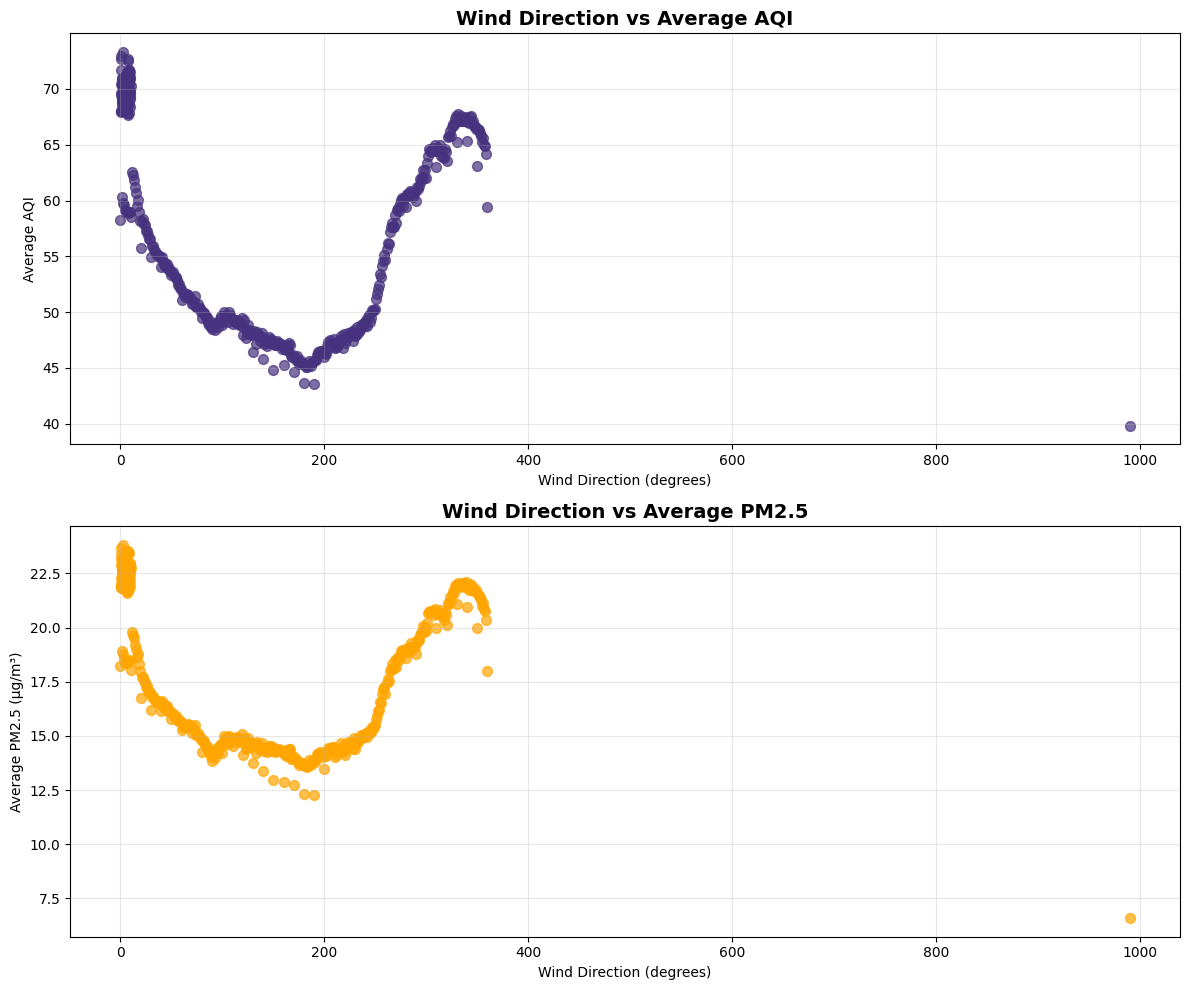

In [25]:
# 9. Wind Impact on Air Quality
wind_analysis = ddf_clean.groupby('winddirec').agg({
    'aqi': 'mean',
    'pm2.5': 'mean'
}).compute().reset_index()

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.scatter(wind_analysis['winddirec'], wind_analysis['aqi'], alpha=0.7, s=50)
plt.title('Wind Direction vs Average AQI', fontsize=14, fontweight='bold')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Average AQI')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.scatter(wind_analysis['winddirec'], wind_analysis['pm2.5'], alpha=0.7, s=50, color='orange')
plt.title('Wind Direction vs Average PM2.5', fontsize=14, fontweight='bold')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Average PM2.5 (μg/m³)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
# 10. Interactive Plotly Visualization for Temporal Trends
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate yearly_analysis if not already computed
yearly_analysis = ddf_clean.groupby('year').agg({
    'aqi': 'mean',
    'pm2.5': 'mean',
    'pm10': 'mean'
}).compute()

yearly_analysis.columns = ['aqi', 'pm2.5', 'pm10']


# Create interactive plot
fig = make_subplots(rows=3, cols=1,
                   subplot_titles=('AQI Trend', 'PM2.5 Trend', 'PM10 Trend'))

fig.add_trace(go.Scatter(x=yearly_analysis.index, y=yearly_analysis['aqi'],
                        mode='lines+markers', name='AQI',
                        line=dict(color='blue', width=2)),
             row=1, col=1)

fig.add_trace(go.Scatter(x=yearly_analysis.index, y=yearly_analysis['pm2.5'],
                        mode='lines+markers', name='PM2.5',
                        line=dict(color='orange', width=2)),
             row=2, col=1)

fig.add_trace(go.Scatter(x=yearly_analysis.index, y=yearly_analysis['pm10'],
                        mode='lines+markers', name='PM10',
                        line=dict(color='green', width=2)),
             row=3, col=1)

fig.update_layout(height=800, title_text="Multi-Year Air Quality Trends",
                  showlegend=False, title_font_size=20)
fig.update_xaxes(title_text="Year", row=3, col=1)
fig.update_yaxes(title_text="AQI", row=1, col=1)
fig.update_yaxes(title_text="PM2.5 (μg/m³)", row=2, col=1)
fig.update_yaxes(title_text="PM10 (μg/m³)", row=3, col=1)

fig.show()

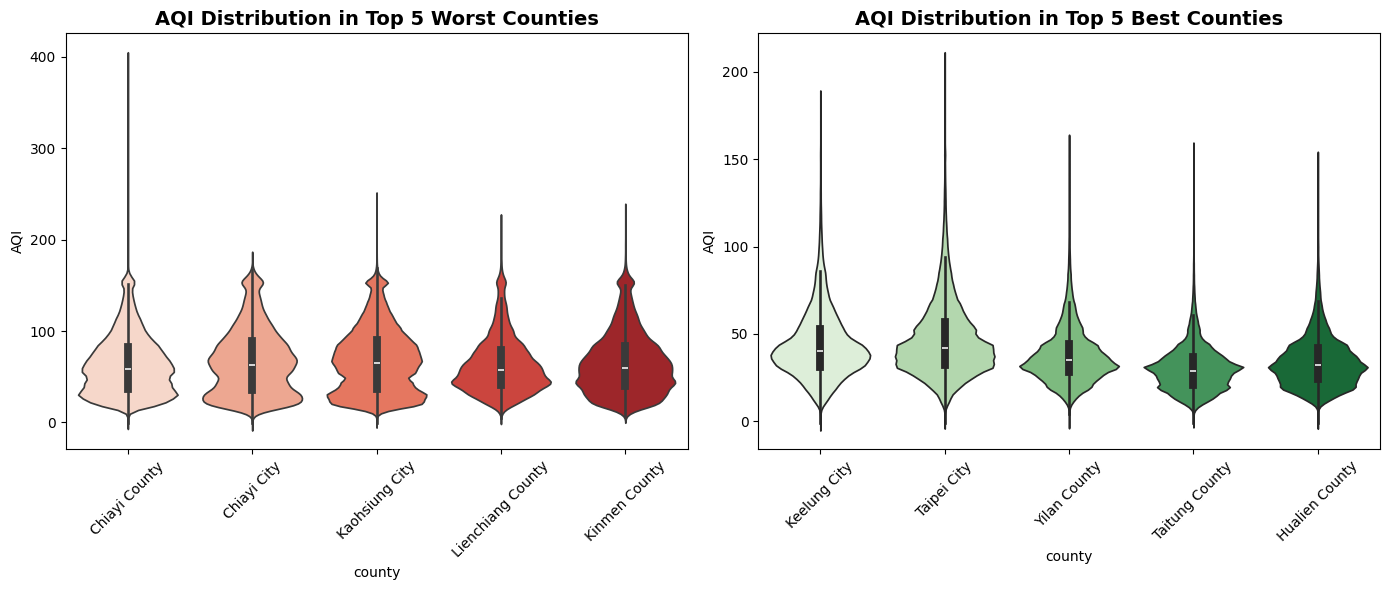

In [27]:
# 11. Violin Plots for Distribution Comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
top_5_counties = county_analysis.head(5).index.tolist()
top_counties_data = ddf_clean[ddf_clean['county'].isin(top_5_counties)].compute()
sns.violinplot(data=top_counties_data, x='county', y='aqi', palette='Reds')
plt.title('AQI Distribution in Top 5 Worst Counties', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('AQI')

plt.subplot(1, 2, 2)
bottom_5_counties = county_analysis.tail(5).index.tolist()
bottom_counties_data = ddf_clean[ddf_clean['county'].isin(bottom_5_counties)].compute()
sns.violinplot(data=bottom_counties_data, x='county', y='aqi', palette='Greens')
plt.title('AQI Distribution in Top 5 Best Counties', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.ylabel('AQI')

plt.tight_layout()
plt.show()

Predictive Analysis

In [28]:
# Install additional libraries for machine learning
!pip install scikit-learn xgboost lightgbm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Prepare data for predictive analysis
# Sample a subset for faster computation (adjust fraction as needed)
df_sample = ddf_clean.sample(frac=0.1).compute()  # 10% sample

print(f"Sample size for predictive analysis: {len(df_sample):,} records")

# Create time-based features
df_sample['day_of_year'] = df_sample['date'].dt.dayofyear
df_sample['week_of_year'] = df_sample['date'].dt.isocalendar().week
df_sample['is_weekend'] = df_sample['day_of_week'].isin([5, 6]).astype(int)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['county', 'season', 'pollutant', 'status']

for col in categorical_cols:
    if col in df_sample.columns:
        le = LabelEncoder()
        df_sample[col] = le.fit_transform(df_sample[col].astype(str))
        label_encoders[col] = le

# Define features and target
features = ['year', 'month', 'day_of_year', 'week_of_year', 'hour', 'day_of_week',
            'is_weekend', 'county', 'so2', 'co', 'o3', 'pm10', 'no2', 'nox', 'no',
            'windspeed', 'winddirec', 'season']

# Use only available features
available_features = [f for f in features if f in df_sample.columns]

X = df_sample[available_features]
y = df_sample['aqi']

print(f"Features used: {available_features}")
print(f"Target variable: AQI")
print(f"Shape: X={X.shape}, y={y.shape}")

Sample size for predictive analysis: 559,119 records
Features used: ['year', 'month', 'day_of_year', 'week_of_year', 'hour', 'day_of_week', 'is_weekend', 'county', 'so2', 'co', 'o3', 'pm10', 'no2', 'nox', 'no', 'windspeed', 'winddirec', 'season']
Target variable: AQI
Shape: X=(559119, 18), y=(559119,)


In [30]:
# Handle missing values in features
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [31]:
# Split data into train and test sets (time-based split)
# Sort by date to ensure temporal order
df_sample_sorted = df_sample.sort_values('date')
split_index = int(0.8 * len(df_sample_sorted))

X_train = X_imputed[:split_index]
X_test = X_imputed[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Train set: {X_train.shape[0]:,} records")
print(f"Test set: {X_test.shape[0]:,} records")
print(f"Time period - Train: {df_sample_sorted['date'].iloc[0]} to {df_sample_sorted['date'].iloc[split_index-1]}")
print(f"Time period - Test: {df_sample_sorted['date'].iloc[split_index]} to {df_sample_sorted['date'].iloc[-1]}")

Train set: 447,295 records
Test set: 111,824 records
Time period - Train: 2016-11-25 13:00:00 to 2023-02-11 07:00:00
Time period - Test: 2023-02-11 07:00:00 to 2024-08-31 23:00:00


In [32]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }

    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

Training Random Forest...
Random Forest: MAE=13.44, RMSE=17.95, R²=0.7165
Training Gradient Boosting...
Gradient Boosting: MAE=14.03, RMSE=18.47, R²=0.6999
Training XGBoost...
XGBoost: MAE=13.53, RMSE=17.92, R²=0.7175
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 447295, number of used features: 18
[LightGBM] [Info] Start training from score 51.985093
LightGBM: MAE=13.31, RMSE=17.75, R²=0.7228
Training Linear Regression...
Linear Regression: MAE=15.56, RMSE=20.95, R²=0.6141
Training Ridge Regression...
Ridge Regression: MAE=15.56, RMSE=20.95, R²=0.6141
